In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.linear_model import *

import lightgbm as lgb

In [3]:
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

train = pd.read_csv("../input/train_sample2.csv", 
                    usecols=['ip', 'app', 'device', 'os', 'channel', 'is_attributed', 'click_time'],
                    dtype=dtypes, nrows=40000000)

In [4]:
train.shape

(40000000, 7)

In [5]:
#Strategy for feature generation
train['click_time'] = pd.to_datetime(train['click_time'])
train['hourofday'] = train['click_time'].dt.hour.astype(np.uint16)
train['dayofweek'] = train['click_time'].dt.dayofweek.astype(np.uint8)

del train['click_time']
train.head()

,ip,app,device,os,channel,is_attributed,hourofday,dayofweek
0,53454,18,1,13,107,0,15,2
1,95766,12,1,19,265,0,15,2
2,44744,15,1,18,245,0,15,2
3,29748,18,1,47,107,0,15,2
4,71017,15,1,35,245,0,15,2


In [6]:
cond = train.hourofday.isin([4]) & (train['dayofweek'] == 3)
tr = train.loc[~cond]
val = train.loc[cond]

print(tr.shape, val.shape)

(35967309, 8) (4032691, 8)


In [7]:
feats = ['ip', 'app', 'device', 'os', 'channel']

In [8]:
model = lgb.LGBMClassifier(n_estimators=1000, max_depth=3, subsample=0.8,
                           num_leaves=8, min_child_samples=2000, n_jobs=-1)

In [9]:
model.fit( tr[feats], tr['is_attributed'], eval_set=[(val[feats], val['is_attributed'])], eval_metric='auc', 
          verbose=10, early_stopping_rounds=100,)

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.805307
[20]	valid_0's auc: 0.805317
[30]	valid_0's auc: 0.889278
[40]	valid_0's auc: 0.929328
[50]	valid_0's auc: 0.929843
[60]	valid_0's auc: 0.934361
[70]	valid_0's auc: 0.93961
[80]	valid_0's auc: 0.940679
[90]	valid_0's auc: 0.942311
[100]	valid_0's auc: 0.943647
[110]	valid_0's auc: 0.945545
[120]	valid_0's auc: 0.947596
[130]	valid_0's auc: 0.948694
[140]	valid_0's auc: 0.949459
[150]	valid_0's auc: 0.950451
[160]	valid_0's auc: 0.951448
[170]	valid_0's auc: 0.952026
[180]	valid_0's auc: 0.95243
[190]	valid_0's auc: 0.953076
[200]	valid_0's auc: 0.953282
[210]	valid_0's auc: 0.953786
[220]	valid_0's auc: 0.954182
[230]	valid_0's auc: 0.954448
[240]	valid_0's auc: 0.954565
[250]	valid_0's auc: 0.954857
[260]	valid_0's auc: 0.955071
[270]	valid_0's auc: 0.955472
[280]	valid_0's auc: 0.955658
[290]	valid_0's auc: 0.955694
[300]	valid_0's auc: 0.956008
[310]	valid_0's auc: 0.956132
[320]	valid_0's au

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=3, min_child_samples=2000,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=1000,
        n_jobs=-1, num_leaves=8, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.8,
        subsample_for_bin=200000, subsample_freq=1)

In [10]:
roc_auc_score(tr['is_attributed'], model.predict_proba(tr[feats])[:,1])

0.963295452902527

In [9]:
import gc
gc.collect()

7

In [10]:
import pickle
with open("../input/ip_device_os_cnt.pkl", "rb") as f:
    user_cnts = pickle.load(f)
    
print(len(user_cnts))
tmp = pd.Series(user_cnts, name='ip_device_os_cnt', dtype=np.uint32)
tmp.index.names = ['ip', 'device', 'os']
display(tmp.head())

del tr, val
train = train.join(tmp, on=['ip', 'device', 'os'], how='left')
tr = train.loc[~cond]
val = train.loc[cond]

print(tr.shape, val.shape)

4058762


ip  device  os
0   0       0      2
1   1       1     16
            2     20
            3     13
            4      4
Name: ip_device_os_cnt, dtype: uint32

(35967309, 9) (4032691, 9)


In [11]:
train.dtypes

ip                  uint32
app                 uint16
device              uint16
os                  uint16
channel             uint16
is_attributed        uint8
hourofday           uint16
dayofweek            uint8
ip_device_os_cnt    uint32
dtype: object

In [18]:
model = lgb.LGBMClassifier(n_estimators=1000, max_depth=3, num_leaves=8, subsample=0.8, colsample_bytree=0.9,
                           min_data_in_leaf=1000, n_jobs=-1, scale_pos_weight=80)

In [17]:
feats1 = feats + ['ip_device_os_cnt'] 

In [19]:
model.fit( tr[feats1], tr['is_attributed'], eval_set=[(val[feats1], val['is_attributed'])], eval_metric='auc', 
          verbose=10, early_stopping_rounds=100,)

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.891993
[20]	valid_0's auc: 0.934866
[30]	valid_0's auc: 0.944667
[40]	valid_0's auc: 0.952315
[50]	valid_0's auc: 0.953893
[60]	valid_0's auc: 0.955746
[70]	valid_0's auc: 0.956726
[80]	valid_0's auc: 0.95762
[90]	valid_0's auc: 0.958552
[100]	valid_0's auc: 0.959399
[110]	valid_0's auc: 0.960156
[120]	valid_0's auc: 0.960637
[130]	valid_0's auc: 0.961227
[140]	valid_0's auc: 0.961563
[150]	valid_0's auc: 0.961874
[160]	valid_0's auc: 0.962154
[170]	valid_0's auc: 0.962323
[180]	valid_0's auc: 0.962471
[190]	valid_0's auc: 0.962657
[200]	valid_0's auc: 0.96277
[210]	valid_0's auc: 0.962913
[220]	valid_0's auc: 0.963001
[230]	valid_0's auc: 0.963149
[240]	valid_0's auc: 0.9633
[250]	valid_0's auc: 0.963384
[260]	valid_0's auc: 0.963441
[270]	valid_0's auc: 0.963568
[280]	valid_0's auc: 0.963582
[290]	valid_0's auc: 0.963653
[300]	valid_0's auc: 0.963766
[310]	valid_0's auc: 0.96383
[320]	valid_0's auc: 

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.9,
        learning_rate=0.1, max_depth=3, min_child_samples=20,
        min_child_weight=0.001, min_data_in_leaf=1000, min_split_gain=0.0,
        n_estimators=1000, n_jobs=-1, num_leaves=8, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        scale_pos_weight=80, silent=True, subsample=0.8,
        subsample_for_bin=200000, subsample_freq=1)

In [14]:
test = pd.read_csv("../input/test.csv", dtype=dtypes)
test = test.join(tmp, on=['ip', 'device', 'os'], how='left')
test.head()

,click_id,ip,app,device,os,channel,click_time,ip_device_os_cnt
0,0,5744,9,1,3,107,2017-11-10 04:00:00,17
1,1,119901,9,1,3,466,2017-11-10 04:00:00,469
2,2,72287,21,1,19,128,2017-11-10 04:00:00,4640
3,3,78477,15,1,13,111,2017-11-10 04:00:00,3448
4,4,123080,12,1,13,328,2017-11-10 04:00:00,266


In [20]:
test_preds = model.predict_proba(test[feats1])[:,1]

sub = pd.DataFrame()
sub['click_id'] = test['click_id']
sub['is_attributed'] = test_preds
sub.to_csv("../output/sub_lgb_ipdeviceoscnt.csv", index=False)
sub.head()

,click_id,is_attributed
0,0,0.000643
1,1,0.000238
2,2,0.000082
3,3,0.000243
4,4,0.000151


In [21]:
del sub

In [18]:
with open("../input/app_cnt.pkl", "rb") as f:
    app_cnts = pickle.load(f)
    
print(len(app_cnts))
tmp = pd.Series(app_cnts, name='app_cnt', dtype=np.uint32)
tmp.index.names = ['app']
tmp.index = tmp.index.levels[0]
display(tmp.head())

#del tr, val
train['app_cnt'] = train.app.map(tmp).astype(np.uint32)
test['app_cnt'] = test.app.map(tmp).astype(np.uint32)
#tr = train.loc[~cond]
#val = train.loc[cond]

#print(tr.shape, val.shape)

769


app
0        5253
1     7548188
2    27982558
3    40579359
4      141860
Name: app_cnt, dtype: uint32

In [19]:
#tmp.index = tmp.index.levels[0]
train.head()

,ip,app,device,os,channel,is_attributed,hourofday,dayofweek,ip_device_os_cnt,app_cnt
0,53454,18,1,13,107,0,15,2,124018,21518031
1,95766,12,1,19,265,0,15,2,97887,31202352
2,44744,15,1,18,245,0,15,2,6517,19260739
3,29748,18,1,47,107,0,15,2,779,21518031
4,71017,15,1,35,245,0,15,2,171,19260739


In [20]:
with open("../input/device_os_cnt.pkl", "rb") as f:
    app_cnts = pickle.load(f)
    
print(len(app_cnts))
tmp = pd.Series(app_cnts, name='device_os_cnt', dtype=np.uint32)
tmp.index.names = ['device','os']
display(tmp.head())

del tr, val
train = train.join(tmp, on=['device','os'], how='left')
test = test.join(tmp, on=['device','os'], how='left')
tr = train.loc[~cond]
val = train.loc[cond]

print(tr.shape, val.shape)

6561


device  os
0       0     513590
        21    151542
        24    519864
        29    112588
        33      7610
Name: device_os_cnt, dtype: uint32

(45967309, 11) (4032691, 11)


In [21]:
#del tmp

In [24]:
gc.collect()

0

In [26]:
feats2 = feats1 + ['device_os_cnt', 'app_cnt'] 
model = lgb.LGBMClassifier(n_estimators=1000, max_depth=3, num_leaves=8, min_child_samples=1000, n_jobs=16,
                          scale_pos_weight=70, subsample=0.9, colsample_bytree=0.9)
model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
          verbose=10, early_stopping_rounds=100,)

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.941966
[20]	valid_0's auc: 0.942359
[30]	valid_0's auc: 0.949081
[40]	valid_0's auc: 0.954572
[50]	valid_0's auc: 0.956057
[60]	valid_0's auc: 0.957429
[70]	valid_0's auc: 0.958669
[80]	valid_0's auc: 0.959943
[90]	valid_0's auc: 0.960338
[100]	valid_0's auc: 0.960931
[110]	valid_0's auc: 0.961314
[120]	valid_0's auc: 0.961487
[130]	valid_0's auc: 0.962138
[140]	valid_0's auc: 0.962447
[150]	valid_0's auc: 0.962731
[160]	valid_0's auc: 0.962904
[170]	valid_0's auc: 0.963069
[180]	valid_0's auc: 0.963268
[190]	valid_0's auc: 0.963408
[200]	valid_0's auc: 0.963457
[210]	valid_0's auc: 0.963634
[220]	valid_0's auc: 0.963714
[230]	valid_0's auc: 0.963798
[240]	valid_0's auc: 0.963935
[250]	valid_0's auc: 0.964001
[260]	valid_0's auc: 0.964096
[270]	valid_0's auc: 0.964177
[280]	valid_0's auc: 0.96424
[290]	valid_0's auc: 0.964335
[300]	valid_0's auc: 0.964425
[310]	valid_0's auc: 0.964524
[320]	valid_0's a

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.9,
        learning_rate=0.1, max_depth=3, min_child_samples=1000,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=1000,
        n_jobs=-1, num_leaves=8, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, scale_pos_weight=70, silent=True,
        subsample=0.9, subsample_for_bin=200000, subsample_freq=1)

In [27]:
with open("../input/ip_cnt.pkl", "rb") as f:
    app_cnts = pickle.load(f)
    
print(len(app_cnts))
tmp = pd.Series(app_cnts, name='ip_cnt', dtype=np.uint32)
tmp.index.names = ['ip']
tmp.index = tmp.index.levels[0]
display(tmp.head())

del tr, val
train['ip_cnt'] = train.ip.map(tmp).astype(np.uint32)
test['ip_cnt'] = test.ip.map(tmp).astype(np.uint32)
tr = train.loc[~cond]
val = train.loc[cond]

#print(tr.shape, val.shape)

364779


ip
0      2
1     97
2      6
3    291
4     39
Name: ip_cnt, dtype: uint32

In [28]:
feats3 = feats2 + ['ip_cnt']
model = lgb.LGBMClassifier(n_estimators=1000, max_depth=3, num_leaves=8, min_child_samples=1000, n_jobs=16,
                          scale_pos_weight=70, subsample=0.9, colsample_bytree=0.9)
model.fit( tr[feats3], tr['is_attributed'], eval_set=[(val[feats3], val['is_attributed'])], eval_metric='auc', 
          verbose=10, early_stopping_rounds=100,)

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.938642
[20]	valid_0's auc: 0.946208
[30]	valid_0's auc: 0.952901
[40]	valid_0's auc: 0.957236
[50]	valid_0's auc: 0.959239
[60]	valid_0's auc: 0.960183
[70]	valid_0's auc: 0.960924
[80]	valid_0's auc: 0.961613
[90]	valid_0's auc: 0.962263
[100]	valid_0's auc: 0.96246
[110]	valid_0's auc: 0.962924
[120]	valid_0's auc: 0.963287
[130]	valid_0's auc: 0.963594
[140]	valid_0's auc: 0.964008
[150]	valid_0's auc: 0.964191
[160]	valid_0's auc: 0.964415
[170]	valid_0's auc: 0.964508
[180]	valid_0's auc: 0.964649
[190]	valid_0's auc: 0.964759
[200]	valid_0's auc: 0.964941
[210]	valid_0's auc: 0.965063
[220]	valid_0's auc: 0.965208
[230]	valid_0's auc: 0.965302
[240]	valid_0's auc: 0.965388
[250]	valid_0's auc: 0.96546
[260]	valid_0's auc: 0.965599
[270]	valid_0's auc: 0.965662
[280]	valid_0's auc: 0.965703
[290]	valid_0's auc: 0.965795
[300]	valid_0's auc: 0.965838
[310]	valid_0's auc: 0.965869
[320]	valid_0's au

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.9,
        learning_rate=0.1, max_depth=3, min_child_samples=1000,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=1000,
        n_jobs=16, num_leaves=8, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, scale_pos_weight=70, silent=True,
        subsample=0.9, subsample_for_bin=200000, subsample_freq=1)

In [29]:
with open("../input/ip_channel_cnt.pkl", "rb") as f:
    app_cnts = pickle.load(f)
    
print(len(app_cnts))
tmp = pd.Series(app_cnts, name='ip_channel_cnt', dtype=np.uint32)
tmp.index.names = ['ip', 'channel']
display(tmp.head())

del tr, val
train = train.join(tmp, on=['ip', 'channel'], how='left')
test = test.join(tmp, on=['ip', 'channel'], how='left')
tr = train.loc[~cond]
val = train.loc[cond]

print(tr.shape, val.shape)

9126766


ip  channel
0   101         2
1   13          5
    101        19
    113        19
    125         2
Name: ip_channel_cnt, dtype: uint32

(45967309, 13) (4032691, 13)


In [32]:
del tmp
gc.collect()

20

In [ ]:
feats4 = feats3 + ['ip_channel_cnt']
model = lgb.LGBMClassifier(n_estimators=1000, max_depth=3, num_leaves=8, min_child_samples=1000, n_jobs=16,
                          scale_pos_weight=70, subsample=0.9, colsample_bytree=0.9, two_round=True)
model.fit( tr[feats4], tr['is_attributed'], eval_set=[(val[feats4], val['is_attributed'])], eval_metric='auc', 
          verbose=10, early_stopping_rounds=100,)

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.945786
[20]	valid_0's auc: 0.946771
[30]	valid_0's auc: 0.951159
[40]	valid_0's auc: 0.957489
[50]	valid_0's auc: 0.959511
[60]	valid_0's auc: 0.960327
[70]	valid_0's auc: 0.961002
[80]	valid_0's auc: 0.961736
[90]	valid_0's auc: 0.962377
[100]	valid_0's auc: 0.96295
[110]	valid_0's auc: 0.963252
[120]	valid_0's auc: 0.963681
[130]	valid_0's auc: 0.96392
[140]	valid_0's auc: 0.964132
[150]	valid_0's auc: 0.964411
[160]	valid_0's auc: 0.964709
[170]	valid_0's auc: 0.964846
[180]	valid_0's auc: 0.965047
[190]	valid_0's auc: 0.965151
[200]	valid_0's auc: 0.965311
[210]	valid_0's auc: 0.965459
[220]	valid_0's auc: 0.965563
[230]	valid_0's auc: 0.965654
[240]	valid_0's auc: 0.965714
[250]	valid_0's auc: 0.965735
[260]	valid_0's auc: 0.965872
[270]	valid_0's auc: 0.965919
[280]	valid_0's auc: 0.965972
[290]	valid_0's auc: 0.966026
[300]	valid_0's auc: 0.966087
[310]	valid_0's auc: 0.966121
[320]	valid_0's au

In [1]:
gc.collect()

NameError: name 'gc' is not defined

In [52]:
train['users_atip'] = train.ip.map(train.groupby('ip')['ip_device_os_cnt'].nunique())

In [53]:
#train.loc[train.ip_device_os_app_cnt == 9289].groupby('channel')['is_attributed'].agg(['mean','count'])

In [54]:
#train.groupby('ip_device_os_app_cnt')['is_attributed'].mean().sort_values(ascending=False)

In [64]:
train['users_atip'] = train['users_atip'].astype(np.uint32)
train['click_rat_ip'] = (train['ip_device_os_cnt']/train['users_atip']*1000).astype(np.uint32)

In [65]:
train.click_rat_ip.value_counts()

1000       221719
2000       185255
3000       143375
4000       120366
500        105056
5000       101828
1500        95589
1746989     88816
6000        85735
1627311     80705
1635270     79814
2500        75482
7000        74946
1518806     73378
666         66809
1417163     66806
1364784     66791
8000        66553
3500        65205
333         64552
1333        62583
9000        60255
1666        56340
4500        52443
10000       52289
2333        51125
11000       50116
998352      49467
1035748     49192
750         48026
            ...  
145750          1
152571          1
772500          1
253666          1
298333          1
60875           1
131833          1
131222          1
44133           1
58714           1
195400          1
250800          1
385500          1
242600          1
29619           1
111571          1
58857           1
575000          1
64272           1
68800           1
188250          1
39857           1
132428          1
119800          1
596000    

In [71]:
test.to_pickle("../input/test_v2.pkl")

In [72]:
del test

In [73]:
gc.collect()

156

In [76]:
del train['app_cnt']

In [81]:
gc.collect()

404

In [83]:
train['hourofday'] = train['hourofday'].astype(np.uint8)

In [85]:
train['ip_device_os_app_cnt'] = train['ip_device_os_app_cnt'].astype(np.uint16)

In [89]:
train['users_atip'] = train['users_atip'].astype(np.uint8)

In [104]:
train['click_rat_ip'] = train['click_rat_ip'].clip(50000).astype(np.uint16)

In [105]:
train.dtypes

ip                      uint32
app                     uint16
device                  uint16
os                      uint16
channel                 uint16
is_attributed            uint8
hourofday                uint8
ip_device_os_cnt        uint32
ip_device_os_app_cnt    uint16
users_atip               uint8
click_rat_ip            uint16
dtype: object

In [95]:
del train['dayofweek']

In [108]:
gc.collect()

333

In [109]:
del model
#tr = train.loc[~cond]
#val = train.loc[cond]

#print(tr.shape, val.shape)

feats3 = ['app', 'ip_device_os_cnt', 'channel', 'device','os'] + ['ip_device_os_app_cnt', 'hourofday', 'users_atip','click_rat_ip'] 
model = lgb.LGBMClassifier(n_estimators=1000, max_depth=3, num_leaves=7, min_child_samples=1000, n_jobs=16,
                          scale_pos_weight=10, two_round=True, subsample=0.8, colsample_bytree=0.8)
model.fit( train.loc[~cond, feats3], train.loc[~cond, 'is_attributed'], 
          eval_set=[(train.loc[cond, feats3], train.loc[cond, 'is_attributed'])], eval_metric='auc', 
          verbose=10, early_stopping_rounds=100,)

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.953201
[20]	valid_0's auc: 0.954585
[30]	valid_0's auc: 0.956105
[40]	valid_0's auc: 0.963248
[50]	valid_0's auc: 0.967001
[60]	valid_0's auc: 0.970085
[70]	valid_0's auc: 0.971773
[80]	valid_0's auc: 0.973203
[90]	valid_0's auc: 0.973628
[100]	valid_0's auc: 0.974419
[110]	valid_0's auc: 0.974827
[120]	valid_0's auc: 0.975524
[130]	valid_0's auc: 0.975953
[140]	valid_0's auc: 0.976287
[150]	valid_0's auc: 0.976764
[160]	valid_0's auc: 0.976923
[170]	valid_0's auc: 0.977191
[180]	valid_0's auc: 0.977465
[190]	valid_0's auc: 0.977745
[200]	valid_0's auc: 0.97796
[210]	valid_0's auc: 0.978795
[220]	valid_0's auc: 0.979364
[230]	valid_0's auc: 0.979647
[240]	valid_0's auc: 0.979857
[250]	valid_0's auc: 0.980055
[260]	valid_0's auc: 0.98031
[270]	valid_0's auc: 0.980456
[280]	valid_0's auc: 0.980684
[290]	valid_0's auc: 0.980847
[300]	valid_0's auc: 0.980967
[310]	valid_0's auc: 0.981073
[320]	valid_0's au

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
        learning_rate=0.1, max_depth=3, min_child_samples=1000,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=1000,
        n_jobs=16, num_leaves=7, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, scale_pos_weight=10, silent=True,
        subsample=0.8, subsample_for_bin=200000, subsample_freq=1,
        two_round=True)

In [110]:
test = pd.read_pickle("../input/test_v2.pkl")
test.head()

,click_id,ip,app,device,os,channel,ip_device_os_cnt,app_cnt,ip_device_os_app_cnt,hourofday,dayofweek
0,0,5744,9,1,3,107,17,NaN,7,4,4
1,1,119901,9,1,3,466,469,NaN,35,4,4
2,2,72287,21,1,19,128,4640,NaN,150,4,4
3,3,78477,15,1,13,111,3448,NaN,274,4,4
4,4,123080,12,1,13,328,266,NaN,45,4,4


In [111]:
#test['click_time'] = pd.to_datetime(test['click_time'])
#test['hourofday'] = test['click_time'].dt.hour.astype(np.uint16)
#test['dayofweek'] = test['click_time'].dt.dayofweek.astype(np.uint8)

#del test['click_time']

#test.head()

In [113]:
test['users_atip'] = test.ip.map(train.groupby('ip')['ip_device_os_cnt'].nunique())
test['users_atip'] = test['users_atip'].fillna(test['users_atip'].median()).astype(np.uint8)
test['click_rat_ip'] = (test['ip_device_os_cnt']/test['users_atip']*1000).clip(50000).astype(np.uint16)

In [114]:
gc.collect()
test.head()

,click_id,ip,app,device,os,channel,ip_device_os_cnt,app_cnt,ip_device_os_app_cnt,hourofday,dayofweek,users_atip,click_rat_ip
0,0,5744,9,1,3,107,17,NaN,7,4,4,26,50000
1,1,119901,9,1,3,466,469,NaN,35,4,4,50,50000
2,2,72287,21,1,19,128,4640,NaN,150,4,4,46,35333
3,3,78477,15,1,13,111,3448,NaN,274,4,4,43,14650
4,4,123080,12,1,13,328,266,NaN,45,4,4,18,50000


In [115]:
test_preds = model.predict_proba(test[feats3])[:,1]

sub = pd.DataFrame()
sub['click_id'] = test['click_id']
sub['is_attributed'] = test_preds
sub.to_csv("../output/sub_lgb_ipdeviceoscnt_v2.csv", index=False)
sub.head()

,click_id,is_attributed
0,0,0.004559
1,1,0.004426
2,2,0.000790
3,3,0.002196
4,4,0.001917


In [118]:
train.groupby('ip_device_os_app_cnt')['is_attributed'].agg(['mean','sum','count'])

,mean,sum,count
ip_device_os_app_cnt,,,
1,0.025080,70329.0,2804222
2,0.011575,26789.0,2314378
3,0.006096,11854.0,1944396
4,0.003917,6554.0,1673345
5,0.002807,4068.0,1448979
6,0.002040,2833.0,1388485
7,0.001697,2021.0,1190989
8,0.001423,1590.0,1117124
9,0.001284,1299.0,1011915


In [182]:
train.is_attributed.sum()

156220

,mean,sum,count
ip_device_os_cnt,,,
1,0.213647,47906.0,224230
2,0.092073,21022.0,228320
3,0.044379,9329.0,210213
4,0.026741,5418.0,202611
5,0.019295,3391.0,175745
6,0.012367,2351.0,190108
7,0.010662,1755.0,164597
8,0.008156,1396.0,171172
9,0.006793,1104.0,162526


/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


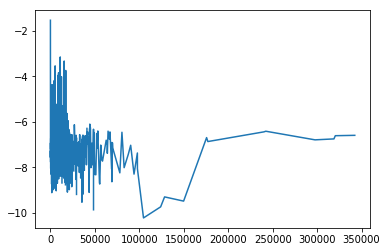

In [122]:
tt = train.groupby('ip_device_os_cnt')['is_attributed'].agg(['mean','sum','count'])
display(tt)


/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


(0, 500)

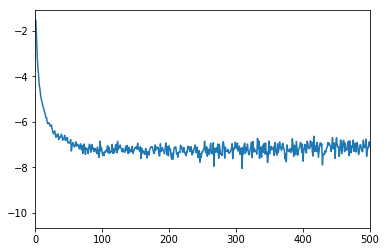

In [123]:
plt.plot(np.log(tt['mean']))
plt.xlim([0, 500])

/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


(500, 1500)

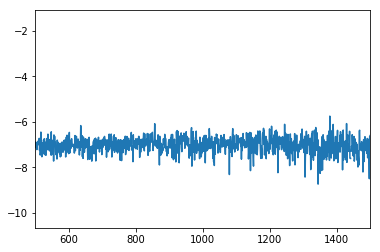

In [124]:
plt.plot(np.log(tt['mean']))
plt.xlim([500, 1500])

/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


(1500, 5000)

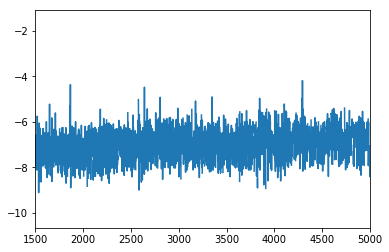

In [125]:
plt.plot(np.log(tt['mean']))
plt.xlim([1500, 5000])

/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


(5000, 10000)

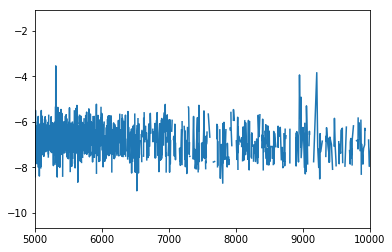

In [126]:
plt.plot(np.log(tt['mean']))
plt.xlim([5000, 10000])

In [176]:
aa = train.loc[train.ip_device_os_cnt == 1].groupby('app')
aa

app
0        387
1       1334
2       9036
3      19785
4         42
5       6751
6       1166
7       1850
8        188
9      23655
10      7068
11       420
12     12703
13      1723
14      2977
15      3976
16       181
17      1127
18     16580
19     55130
20       163
21      5098
22       112
23        44
24       121
25         2
26       170
27       555
28        15
29      8422
       ...  
502        4
503        1
504        8
518        1
548        1
553        2
556        7
557        1
566        1
569        1
575        3
610        1
618        2
622        1
624        1
634        2
654        1
663        1
666        1
672        3
677        1
720        1
742        1
744        1
753        4
760        1
761        1
762        1
763        1
765        1
Length: 345, dtype: int64

In [177]:
train['sec_app_cnt'] = train.app.map(aa).fillna(0).astype(np.uint32)

In [179]:
tb = train.loc[train.ip_device_os_cnt == 1].groupby('sec_app_cnt')['is_attributed'].agg(['mean', 'sum', 'count'])
tb

,mean,sum,count
sec_app_cnt,,,
1,0.183333,11.0,60
2,0.189655,11.0,58
3,0.095238,4.0,42
4,0.250000,15.0,60
5,0.080000,4.0,50
6,0.000000,0.0,36
7,0.071429,5.0,70
8,0.300000,12.0,40
9,0.055556,3.0,54


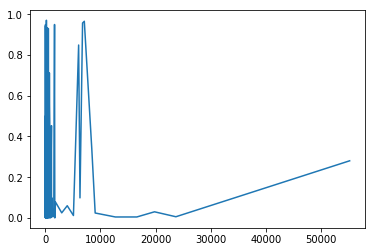

In [180]:
plt.plot(tb['mean'])

In [181]:
tb.loc[tb['count'] > 100].sort_values(by='mean', ascending=False)

,mean,sum,count
sec_app_cnt,,,
201,0.970149,195.0,201
7068,0.965054,6821.0,7068
6751,0.956599,6458.0,6751
1674,0.949223,1589.0,1674
346,0.933526,323.0,346
555,0.929730,516.0,555
234,0.923077,216.0,234
117,0.897436,105.0,117
123,0.873984,215.0,246


In [183]:
with open("../input/ip_cnt.pkl", "rb") as f:
    app_cnts = pickle.load(f)
    
print(len(app_cnts))
tmp = pd.Series(app_cnts, name='ip_cnt', dtype=np.uint32)
tmp.index.names = ['ip']
tmp.index = tmp.index.levels[0]
display(tmp.head())

#del tr, val
train['ip_cnt'] = train.app.map(tmp).astype(np.uint32)
test['ip_cnt'] = test.app.map(tmp).astype(np.uint32)

364779


ip
0      2
1     97
2      6
3    291
4     39
Name: ip_cnt, dtype: uint32

In [184]:
train.groupby('ip_cnt')['is_attributed'].agg(['mean', 'sum', 'count'])

,mean,sum,count
ip_cnt,,,
1,0.000716,4507.0,6292083
2,0.002266,3760.0,1659217
3,0.001970,908.0,461029
4,0.000240,1130.0,4699076
5,0.053069,517.0,9742
6,0.000224,1694.0,7563604
7,0.000534,1.0,1874
8,0.095683,614.0,6417
9,0.001946,2771.0,1423649


In [ ]:
lgb.plot_importance(model)